In [1]:
import sys
sys.path.append('/content/drive/MyDrive/EPAM/datasets/predict_future_sales')

In [2]:
GDRIVE_PATH = '/content/drive/MyDrive/EPAM/datasets/predict_future_sales/'

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
import lightgbm
import xgboost
import torch.nn as nn
from importlib import reload
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from functools import reduce
import statistics 
import main as tsm
import cross_valid as tscv

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/monthly_sales_train.csv', index_col=None)
items = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/items.csv', index_col='item_id')
items_cat = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/item_categories.csv', index_col='item_category_id')
city = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/city_copy.csv', index_col=None)
shops = pd.read_csv('/content/drive/MyDrive/EPAM/datasets/predict_future_sales/shops_copy.csv', index_col='shop_id')

In [5]:
columns = ['shop_id','item_id','date_block_num']

In [6]:
data

,shop_id,item_id,date_block_num,item_price,item_cat,city_id,year,month,item_cnt_month,population,mean_shop_price,median_shop_price,mean_item_cnt_month_shop,median_item_cnt_month_shop
0,0,30,0,265.0,40,4,2013,1,0.0,286,436.85233,192.5,1.549444,1.0
1,0,30,1,265.0,40,4,2013,2,31.0,286,433.73575,190.0,1.701944,1.0
2,0,30,2,265.0,40,4,2013,3,0.0,286,433.73575,190.0,0.000000,0.0
3,0,30,3,265.0,40,4,2013,4,0.0,286,433.73575,190.0,0.000000,0.0
4,0,30,4,265.0,40,4,2013,5,0.0,286,433.73575,190.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14420211,59,22167,29,299.0,49,2,2015,6,0.0,604,812.86880,349.0,0.124455,0.0
14420212,59,22167,30,299.0,49,2,2015,7,0.0,604,812.08325,349.0,0.135224,0.0
14420213,59,22167,31,299.0,49,2,2015,8,0.0,604,805.85320,349.0,0.165485,0.0
14420214,59,22167,32,299.0,49,2,2015,9,0.0,604,803.64886,349.0,0.124591,0.0


In [7]:
#test_data = pd.read_csv(GDRIVE_PATH + 'test.csv', index_col='ID')
#test_data

In [8]:
items

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40
...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",31
22166,Язык запросов 1С:Предприятия [Цифровая версия],54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49


In [9]:
#len(list(set(data['item_id'])-set(test_data['item_id'])))

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     int64  
 1   item_id                     int64  
 2   date_block_num              int64  
 3   item_price                  float64
 4   item_cat                    int64  
 5   city_id                     int64  
 6   year                        int64  
 7   month                       int64  
 8   item_cnt_month              float64
 9   population                  int64  
 10  mean_shop_price             float64
 11  median_shop_price           float64
 12  mean_item_cnt_month_shop    float64
 13  median_item_cnt_month_shop  float64
dtypes: float64(6), int64(8)
memory usage: 1.5 GB


In [11]:
np.iinfo(np.uint16)

iinfo(min=0, max=65535, dtype=uint16)

In [12]:
data['year'] = data['year']%10 #clown trick
data[['shop_id','date_block_num','city_id','month','item_cat','year']] = data[['shop_id','date_block_num','city_id','month','item_cat','year']].astype(np.uint8)
data['item_id'] = data['item_id'].astype(np.uint16)
data['population'] = data['population'].astype(np.uint16)
data[['item_cnt_month','item_price','mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop']] = data[['item_cnt_month','item_price','mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop']].astype(np.float32)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14420216 entries, 0 to 14420215
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     uint8  
 1   item_id                     uint16 
 2   date_block_num              uint8  
 3   item_price                  float32
 4   item_cat                    uint8  
 5   city_id                     uint8  
 6   year                        uint8  
 7   month                       uint8  
 8   item_cnt_month              float32
 9   population                  uint16 
 10  mean_shop_price             float32
 11  median_shop_price           float32
 12  mean_item_cnt_month_shop    float32
 13  median_item_cnt_month_shop  float32
dtypes: float32(6), uint16(2), uint8(6)
memory usage: 467.6 MB


In [14]:
#mean_item_cat_price = data.groupby(['item_cat','date_block_num'])['item_price'].mean()
#data['mean_item_cat_price'] = pd.Series(None)
#for itcat, date in mean_item_cat_price.index:
    

In [15]:
data.set_index(columns, inplace=True)
data

item_price  ...  median_item_cnt_month_shop
shop_id item_id date_block_num              ...                            
0       30      0                    265.0  ...                         1.0
                1                    265.0  ...                         1.0
                2                    265.0  ...                         0.0
                3                    265.0  ...                         0.0
                4                    265.0  ...                         0.0
...                                    ...  ...                         ...
59      22167   29                   299.0  ...                         0.0
                30                   299.0  ...                         0.0
                31                   299.0  ...                         0.0
                32                   299.0  ...                         0.0
                33                   299.0  ...                         0.0

[14420216 rows x 11 columns]

In [16]:
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

In [17]:
data['income'] = (data['item_price']*data['item_cnt_month']).astype(np.float32)

In [18]:
reload(tsm)
train, new_features = tsm.feature_extractor(data, gcols=columns[:2], inplace=False, lagged={
    'columns' : ['item_cnt_month']*3 + ['mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop'],
    'lags' : [1,2,3] + [1]*4
}, window={
    'columns' : ['item_cnt_month']*2 + ['item_price']*2,
    'types' : ['E']*2 + ['R']*2,
    'lags' : [2]*2 + [3]*2,
    'funcs' : [np.median, np.mean, np.min, np.max]
})
print(new_features)

['item_cnt_month_[1]', 'item_cnt_month_[2]', 'item_cnt_month_[3]', 'mean_shop_price_[1]', 'median_shop_price_[1]', 'mean_item_cnt_month_shop_[1]', 'median_item_cnt_month_shop_[1]', 'item_cnt_month_E[2]_median', 'item_cnt_month_E[2]_mean', 'item_price_R[3]_amin', 'item_price_R[3]_amax']


In [19]:
temp = data.groupby(columns[:2],as_index=False)

In [20]:
temp

In [21]:
#ttemp = temp['item_cnt_month'].expanding(2).mean().drop(columns=columns[:2])

In [22]:
#train.index

In [23]:
#ttemp.index

In [24]:
#train[['item_cnt_month_E[2]_mean']] = temp['item_cnt_month'].expanding(2).mean()

In [25]:
#train[['item_cnt_month_E[2]_median']] = temp['item_cnt_month'].expanding(2).median()

In [26]:
#train[['item_price_R[3]_amin']] = temp['item_cnt_month'].rolling(3).min()

In [27]:
#train[['item_price_R[3]_amax']] = temp['item_cnt_month'].rolling(3).max()

In [28]:
#train

In [29]:
#train.drop(columns=['item_cnt_month_E[2]_median_[1]','item_cnt_month_E[2]_mean_[1]','income_[1]','income_[2]','income_[3]'], inplace=True)
#train

In [30]:
tsm.feature_extractor(train, gcols=columns[:2], inplace=True, lagged={
    'columns' : ['item_cnt_month_E[2]_median']*3+['item_cnt_month_E[2]_mean']*3 + ['income']*3,
    'lags' : [1,2,3]*3
})

(                                item_price  item_cat  ...  income_[2]  income_[3]
 shop_id item_id date_block_num                        ...                        
 0       30      0                    265.0        40  ...         NaN         NaN
                 1                    265.0        40  ...         NaN         NaN
                 2                    265.0        40  ...         0.0         NaN
                 3                    265.0        40  ...      8215.0         0.0
                 4                    265.0        40  ...         0.0      8215.0
 ...                                    ...       ...  ...         ...         ...
 59      22167   29                   299.0        49  ...         0.0         0.0
                 30                   299.0        49  ...         0.0         0.0
                 31                   299.0        49  ...         0.0         0.0
                 32                   299.0        49  ...         0.0         0.0
    

In [31]:
tsm.feature_extractor(train, gcols=columns[:2], inplace=True, lagged={
    'columns' : ['item_price', 'item_price_R[3]_amin',  'item_price_R[3]_amax'],
    'lags' : [1]*3
})

(                                item_price  ...  item_price_R[3]_amax_[1]
 shop_id item_id date_block_num              ...                          
 0       30      0                    265.0  ...                       NaN
                 1                    265.0  ...                       NaN
                 2                    265.0  ...                       NaN
                 3                    265.0  ...                     265.0
                 4                    265.0  ...                     265.0
 ...                                    ...  ...                       ...
 59      22167   29                   299.0  ...                     299.0
                 30                   299.0  ...                     299.0
                 31                   299.0  ...                     299.0
                 32                   299.0  ...                     299.0
                 33                   299.0  ...                     299.0
 
 [14420216 rows x 35 co

In [32]:
train['MAX-MIN_item_price_R[3]_maxmin_[1]'] = train['item_price_R[3]_amax_[1]']-train['item_price_R[3]_amin_[1]']

In [33]:
train['population'] = train['population'].astype(np.uint16)

In [34]:
tsm.feature_extractor(train,gcols=columns[:2],inplace=True,lagged={
    'columns' : ['population'],
    'lags' : [1]
    })

(                                item_price  ...  population_[1]
 shop_id item_id date_block_num              ...                
 0       30      0                    265.0  ...             NaN
                 1                    265.0  ...           286.0
                 2                    265.0  ...           286.0
                 3                    265.0  ...           286.0
                 4                    265.0  ...           286.0
 ...                                    ...  ...             ...
 59      22167   29                   299.0  ...           604.0
                 30                   299.0  ...           604.0
                 31                   299.0  ...           604.0
                 32                   299.0  ...           604.0
                 33                   299.0  ...           604.0
 
 [14420216 rows x 37 columns], ['population_[1]'])

In [35]:
list(train.columns)

['item_price',
 'item_cat',
 'city_id',
 'year',
 'month',
 'item_cnt_month',
 'population',
 'mean_shop_price',
 'median_shop_price',
 'mean_item_cnt_month_shop',
 'median_item_cnt_month_shop',
 'income',
 'item_cnt_month_[1]',
 'item_cnt_month_[2]',
 'item_cnt_month_[3]',
 'mean_shop_price_[1]',
 'median_shop_price_[1]',
 'mean_item_cnt_month_shop_[1]',
 'median_item_cnt_month_shop_[1]',
 'item_cnt_month_E[2]_median',
 'item_cnt_month_E[2]_mean',
 'item_price_R[3]_amin',
 'item_price_R[3]_amax',
 'item_cnt_month_E[2]_median_[1]',
 'item_cnt_month_E[2]_median_[2]',
 'item_cnt_month_E[2]_median_[3]',
 'item_cnt_month_E[2]_mean_[1]',
 'item_cnt_month_E[2]_mean_[2]',
 'item_cnt_month_E[2]_mean_[3]',
 'income_[1]',
 'income_[2]',
 'income_[3]',
 'item_price_[1]',
 'item_price_R[3]_amin_[1]',
 'item_price_R[3]_amax_[1]',
 'MAX-MIN_item_price_R[3]_maxmin_[1]',
 'population_[1]']

In [36]:
#train[['item_cnt_month_E[2]_median_[1]']] = train[['item_cnt_month_E[2]_median_[1]']].astype(np.float32)

In [37]:
train[['item_cnt_month_E[2]_median_[1]','item_cnt_month_E[2]_median_[2]','item_cnt_month_E[2]_median_[3]','item_cnt_month_E[2]_mean_[1]','item_cnt_month_E[2]_mean_[2]','item_cnt_month_E[2]_mean_[3]',
       'item_price_R[3]_amin_[1]','item_price_R[3]_amax_[1]','MAX-MIN_item_price_R[3]_maxmin_[1]']] = train[['item_cnt_month_E[2]_median_[1]',
                                                                                                                               'item_cnt_month_E[2]_median_[2]','item_cnt_month_E[2]_median_[3]',
                                                                                                                               'item_cnt_month_E[2]_mean_[1]','item_cnt_month_E[2]_mean_[2]',
                                                                                                                               'item_cnt_month_E[2]_mean_[3]','item_price_R[3]_amin_[1]',
                                                                                                                               'item_price_R[3]_amax_[1]','MAX-MIN_item_price_R[3]_maxmin_[1]']].astype(np.float32)
#train[['population_[1]']] = train[['population_[1]']].astype(np.uint16)

In [38]:
train[['item_price','mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop',
       'income','item_cnt_month_E[2]_median','item_cnt_month_E[2]_mean','item_price_R[3]_amin','item_price_R[3]_amax']] = train[['item_price','mean_shop_price','median_shop_price',
                                                                                                                                 'mean_item_cnt_month_shop','median_item_cnt_month_shop',
                                                                                                                                 'income','item_cnt_month_E[2]_median','item_cnt_month_E[2]_mean',
                                                                                                                                 'item_price_R[3]_amin','item_price_R[3]_amax']].astype(np.float32)

In [39]:
current_time_features = train[['item_price','population','mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop','income','item_cnt_month_E[2]_median',
                               'item_cnt_month_E[2]_mean','item_price_R[3]_amin','item_price_R[3]_amax']].copy()

In [40]:
#train.drop(columns=['item_price','population','mean_shop_price','median_shop_price','mean_item_cnt_month_shop','median_item_cnt_month_shop','income','item_cnt_month_E[2]_median',
#                               'item_cnt_month_E[2]_mean','item_price_R[3]_amin','item_price_R[3]_amax'],inplace=True)

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14420216 entries, (0, 30, 0) to (59, 22167, 33)
Data columns (total 37 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   item_price                          float32
 1   item_cat                            uint8  
 2   city_id                             uint8  
 3   year                                uint8  
 4   month                               uint8  
 5   item_cnt_month                      float32
 6   population                          uint16 
 7   mean_shop_price                     float32
 8   median_shop_price                   float32
 9   mean_item_cnt_month_shop            float32
 10  median_item_cnt_month_shop          float32
 11  income                              float32
 12  item_cnt_month_[1]                  float32
 13  item_cnt_month_[2]                  float32
 14  item_cnt_month_[3]                  float32
 15  mean_shop_price_[1]            

In [42]:
reload(tscv)

<module 'cross_valid' from '/content/drive/MyDrive/EPAM/datasets/predict_future_sales/cross_valid.py'>

# DecisionTreeRegressor and DecisionTreeClassifier

In [6]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [7]:
#features = [col for col in list(train.columns) + columns if col != 'item_cnt_month']
#target = 'item_cnt_month'

In [8]:
#features

In [9]:
#target

In [10]:
TRAIN_LOSS = {}
TEST_LOSS = {}

In [11]:
train

NameError: ignored

In [12]:
reload(tscv)

<module 'cross_valid' from '/content/drive/MyDrive/EPAM/datasets/predict_future_sales/cross_valid.py'>

In [13]:
def plot_losses(train_losses, test_losses):
    for train, test in zip(train_losses.items(), test_losses.items()):
        validate_len = len(train[1])
        plt.plot(np.arange(3,3+validate_len), train[1], label=train[0] + '_train')
        plt.plot(np.arange(3,3+validate_len), test[1], label=test[0] + '_test')
        plt.legend()
        plt.show()

In [14]:
def get_X_y(train_data, test_data, features, target, to_numpy):
    if to_numpy is True:
        X_train, y_train = train_data[features].to_numpy(), np.reshape(train_data[target].to_numpy(),(-1,1))
        X_test, y_test = test_data[features].to_numpy(), np.reshape(test_data[target].to_numpy(),(-1,1))
    else:
        X_train, y_train = train_data[features], train_data[target]
        X_test, y_test = test_data[features], test_data[target]
    return X_train, y_train, X_test, y_test

In [15]:
def validate_model(model, CV, TRAIN_LOSS, TEST_LOSS, print_count=False, to_numpy=True):
    count = 0
    for train_data, test_data in CV.split():

        X_train, y_train, X_test, y_test = get_X_y(train_data, test_data, features, target, to_numpy=to_numpy)
        
        #model
        model.fit(X_train, y_train)
        #print(X_train,y_train)
        #print(type(X_train))
        #print(model.predict(X_train))
        y_hat_train = np.reshape(model.predict(X_train),(-1,1)) if to_numpy else model.predict(X_train)
        y_hat_test = np.reshape(model.predict(X_test),(-1,1)) if to_numpy else model.predict(X_test)
        #print(X_test,y_test)
        TRAIN_LOSS['WAPE'].append(tsm.WAPE(y_train,y_hat_train,10**(-1)))
        TRAIN_LOSS['RMSE'].append(tsm.RMSE(y_train,y_hat_train))
        TRAIN_LOSS['MAE'].append(tsm.MAE(y_train, y_hat_train))

        TEST_LOSS['WAPE'].append(tsm.WAPE(y_test, y_hat_test,10**(-1)))
        TEST_LOSS['RMSE'].append(tsm.RMSE(y_test,y_hat_test))
        TEST_LOSS['MAE'].append(tsm.MAE(y_test, y_hat_test))
        if print_count is True:
            count += 1
            print(count)
    return model

In [53]:
cv_data = train.drop(columns=current_time_features.columns).dropna().reset_index()
#cv_data.to_csv(GDRIVE_PATH+'cv_data.csv')
cv_data['population_[1]'] = cv_data['population_[1]'].astype(np.uint16)
cv_data[['shop_id','date_block_num']] = cv_data[['shop_id','date_block_num']].astype(np.uint8)
cv_data[['item_id']] = cv_data[['item_id']].astype(np.uint16)
cv_data.index = cv_data['date_block_num']
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 12723720 entries, 4 to 33
Data columns (total 29 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   shop_id                             uint8  
 1   item_id                             uint16 
 2   date_block_num                      uint8  
 3   item_cat                            uint8  
 4   city_id                             uint8  
 5   year                                uint8  
 6   month                               uint8  
 7   item_cnt_month                      float32
 8   item_cnt_month_[1]                  float32
 9   item_cnt_month_[2]                  float32
 10  item_cnt_month_[3]                  float32
 11  mean_shop_price_[1]                 float32
 12  median_shop_price_[1]               float32
 13  mean_item_cnt_month_shop_[1]        float32
 14  median_item_cnt_month_shop_[1]      float32
 15  item_cnt_month_E[2]_median_[1]      float32
 16  ite

In [16]:
cv_data = pd.read_csv(GDRIVE_PATH + 'cv_data.csv')
cv_data.drop(columns=['date_block_num.1'], inplace=True)
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12723720 entries, 0 to 12723719
Data columns (total 29 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   date_block_num                      int64  
 1   shop_id                             int64  
 2   item_id                             int64  
 3   item_cat                            int64  
 4   city_id                             int64  
 5   year                                int64  
 6   month                               int64  
 7   item_cnt_month                      float64
 8   item_cnt_month_[1]                  float64
 9   item_cnt_month_[2]                  float64
 10  item_cnt_month_[3]                  float64
 11  mean_shop_price_[1]                 float64
 12  median_shop_price_[1]               float64
 13  mean_item_cnt_month_shop_[1]        float64
 14  median_item_cnt_month_shop_[1]      float64
 15  item_cnt_month_E[2]_median_[1]      float64
 16

In [17]:
cv_data[['shop_id','date_block_num','item_cat','city_id','year','month']] = cv_data[['shop_id','date_block_num','item_cat','city_id','year','month']].astype(np.uint8)
cv_data[['item_id','population_[1]']] = cv_data[['item_id','population_[1]']].astype(np.uint16)
cv_data[['item_cnt_month','item_cnt_month_[1]','item_cnt_month_[2]','item_cnt_month_[3]',
         'mean_shop_price_[1]','median_shop_price_[1]','mean_item_cnt_month_shop_[1]',
         'median_item_cnt_month_shop_[1]','item_cnt_month_E[2]_median_[1]','item_cnt_month_E[2]_median_[2]',
         'item_cnt_month_E[2]_median_[3]','item_cnt_month_E[2]_mean_[1]','item_cnt_month_E[2]_mean_[2]','item_cnt_month_E[2]_mean_[3]',
         'income_[1]','income_[2]','income_[3]','item_price_[1]','item_price_R[3]_amin_[1]','item_price_R[3]_amax_[1]','MAX-MIN_item_price_R[3]_maxmin_[1]']] = cv_data[['item_cnt_month','item_cnt_month_[1]','item_cnt_month_[2]','item_cnt_month_[3]',
         'mean_shop_price_[1]','median_shop_price_[1]','mean_item_cnt_month_shop_[1]',
         'median_item_cnt_month_shop_[1]','item_cnt_month_E[2]_median_[1]','item_cnt_month_E[2]_median_[2]',
         'item_cnt_month_E[2]_median_[3]','item_cnt_month_E[2]_mean_[1]','item_cnt_month_E[2]_mean_[2]','item_cnt_month_E[2]_mean_[3]',
         'income_[1]','income_[2]','income_[3]','item_price_[1]','item_price_R[3]_amin_[1]','item_price_R[3]_amax_[1]','MAX-MIN_item_price_R[3]_maxmin_[1]']].astype(np.float32)
cv_data.info()

#cv_data[['shop_id','date_block_num']] = cv_data[['shop_id','date_block_num']].astype(np.uint8)
#cv_data['item_id'] = cv_data['item_id'].astype(np.uint16)
#cv_data['population_[1]'] = cv_data['population_[1]'].astype(np.uint16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12723720 entries, 0 to 12723719
Data columns (total 29 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   date_block_num                      uint8  
 1   shop_id                             uint8  
 2   item_id                             uint16 
 3   item_cat                            uint8  
 4   city_id                             uint8  
 5   year                                uint8  
 6   month                               uint8  
 7   item_cnt_month                      float32
 8   item_cnt_month_[1]                  float32
 9   item_cnt_month_[2]                  float32
 10  item_cnt_month_[3]                  float32
 11  mean_shop_price_[1]                 float32
 12  median_shop_price_[1]               float32
 13  mean_item_cnt_month_shop_[1]        float32
 14  median_item_cnt_month_shop_[1]      float32
 15  item_cnt_month_E[2]_median_[1]      float32
 16

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [18]:
#cv_data.info()

In [19]:
cv_data.index = cv_data['date_block_num']

In [20]:
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 12723720 entries, 4 to 33
Data columns (total 29 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   date_block_num                      uint8  
 1   shop_id                             uint8  
 2   item_id                             uint16 
 3   item_cat                            uint8  
 4   city_id                             uint8  
 5   year                                uint8  
 6   month                               uint8  
 7   item_cnt_month                      float32
 8   item_cnt_month_[1]                  float32
 9   item_cnt_month_[2]                  float32
 10  item_cnt_month_[3]                  float32
 11  mean_shop_price_[1]                 float32
 12  median_shop_price_[1]               float32
 13  mean_item_cnt_month_shop_[1]        float32
 14  median_item_cnt_month_shop_[1]      float32
 15  item_cnt_month_E[2]_median_[1]      float32
 16  ite

In [21]:
min(cv_data.index)

4

In [22]:
CV = tscv.CrossValid(data=cv_data,train_begin=min(cv_data.index),train_end=34, test_end=34, dtype='DataFrame')

In [23]:
features = [col for col in list(cv_data.columns) if col != 'item_cnt_month']
target = 'item_cnt_month'

In [24]:
features

['date_block_num',
 'shop_id',
 'item_id',
 'item_cat',
 'city_id',
 'year',
 'month',
 'item_cnt_month_[1]',
 'item_cnt_month_[2]',
 'item_cnt_month_[3]',
 'mean_shop_price_[1]',
 'median_shop_price_[1]',
 'mean_item_cnt_month_shop_[1]',
 'median_item_cnt_month_shop_[1]',
 'item_cnt_month_E[2]_median_[1]',
 'item_cnt_month_E[2]_median_[2]',
 'item_cnt_month_E[2]_median_[3]',
 'item_cnt_month_E[2]_mean_[1]',
 'item_cnt_month_E[2]_mean_[2]',
 'item_cnt_month_E[2]_mean_[3]',
 'income_[1]',
 'income_[2]',
 'income_[3]',
 'item_price_[1]',
 'item_price_R[3]_amin_[1]',
 'item_price_R[3]_amax_[1]',
 'MAX-MIN_item_price_R[3]_maxmin_[1]',
 'population_[1]']

In [25]:
cv_data['y_hat_mean'] = cv_data.groupby(columns[:2])['item_cnt_month_[1]'].apply(lambda x : x.rolling(2).mean())

In [26]:
cv_data['y_hat_median'] = cv_data.groupby(columns[:2])['item_cnt_month_[1]'].apply(lambda x : x.rolling(3).median())

In [27]:
temp = cv_data[['item_cnt_month','y_hat_mean']].dropna()
tsm.WAPE(temp['item_cnt_month'],temp['y_hat_mean'])

1.1284396411754185

In [28]:
tsm.RMSE(temp['item_cnt_month'],temp['y_hat_mean'])

2.4866233643674978

In [29]:
tsm.MAE(temp['item_cnt_month'],temp['y_hat_mean'])

0.2778908754401364

In [30]:
temp = cv_data[['item_cnt_month','y_hat_median']].dropna()
tsm.WAPE(temp['item_cnt_month'],temp['y_hat_median'])

1.0203066241682217

In [31]:
tsm.RMSE(temp['item_cnt_month'],temp['y_hat_median'])

2.4087685672867947

In [32]:
tsm.MAE(temp['item_cnt_month'],temp['y_hat_median'])

0.2494592214945225

In [33]:
cv_data.drop(columns=['y_hat_mean','y_hat_median'], inplace=True)

In [34]:
#cv_data['y_hat_mmean'] = cv_data.groupby(columns[:2])['item_cnt_month_[1]'].apply(lambda x : x.rolling(2).mean())

In [35]:
#cv_data.to_csv(GDRIVE_PATH+'cv_data.csv')
#train.reset_index().to_csv(GDRIVE_PATH+'something.csv',index_label=None,index=None)

In [36]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [37]:
TRAIN_LOSS, TEST_LOSS = {}, {}

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


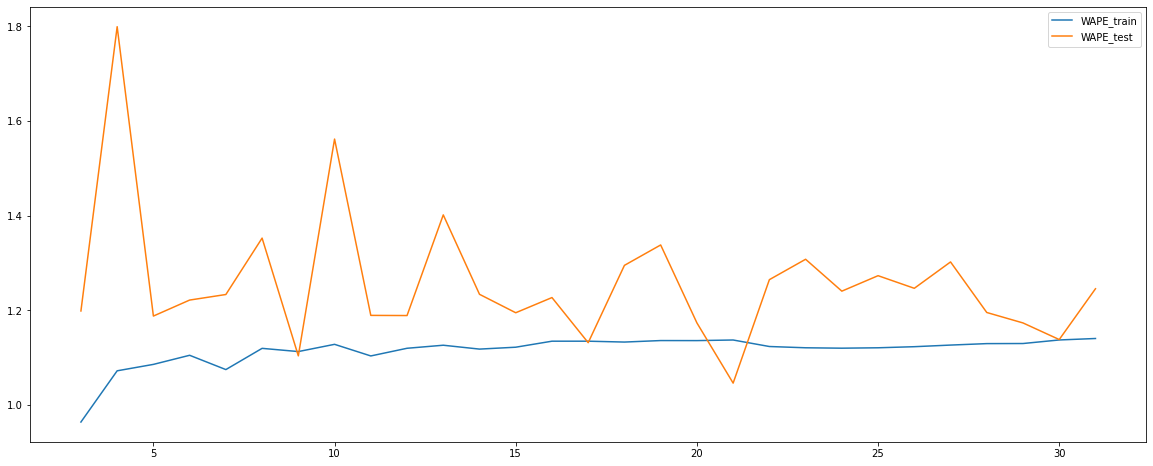

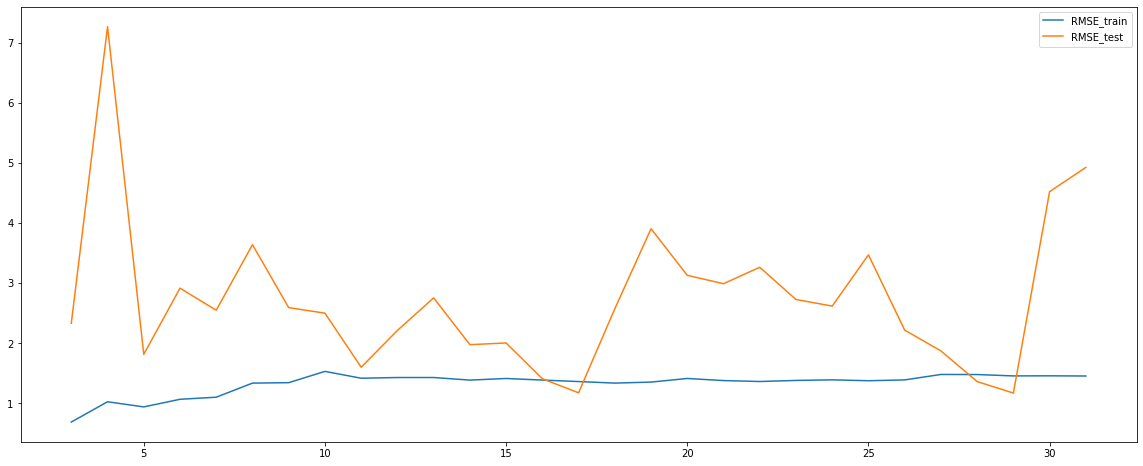

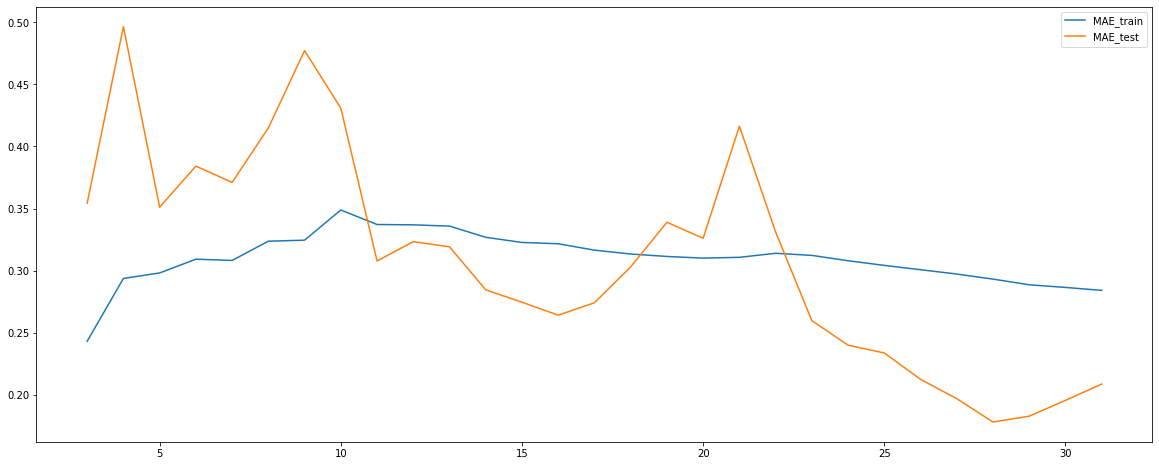

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


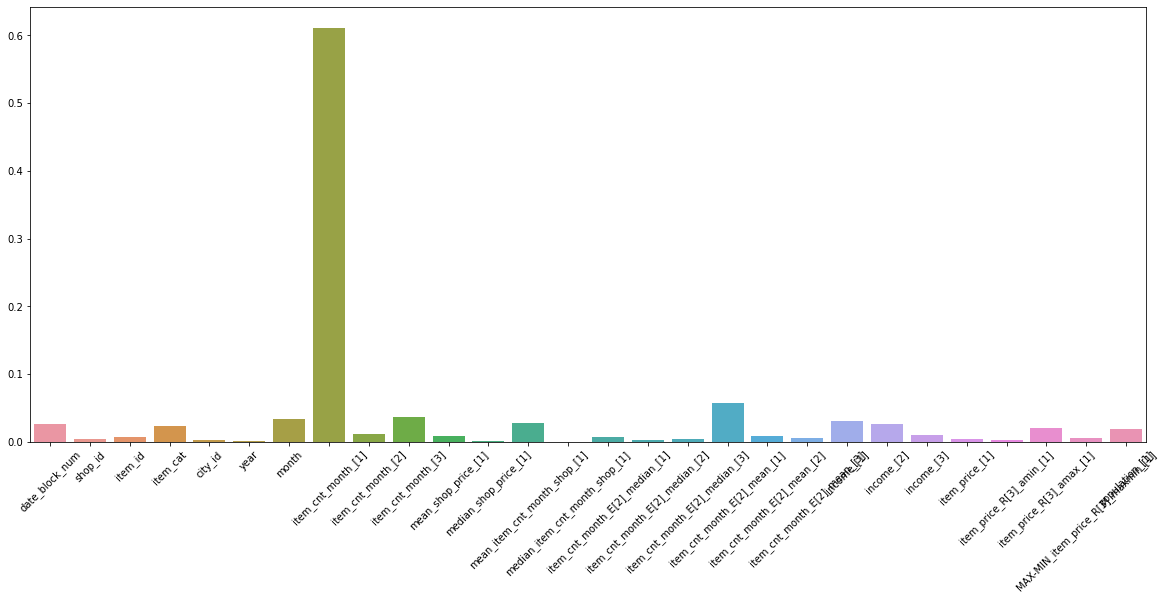

In [38]:
rcParams['figure.figsize'] = 20, 8

TRAIN_LOSS['DTR_15'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['DTR_15'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
DTR_15 = DecisionTreeRegressor(criterion='squared_error', max_depth=15)
DTR_15_fitted = validate_model(DTR_15, CV, TRAIN_LOSS['DTR_15'], TEST_LOSS['DTR_15'], print_count=True, to_numpy=False)
plot_losses(TRAIN_LOSS['DTR_15'], TEST_LOSS['DTR_15'])
sns.barplot(features,DTR_15_fitted.feature_importances_)
plt.xticks(rotation=45)
plt.show()

In [39]:
#cv_data.drop(columns=['date_block_num.1'], inplace=True)

In [40]:
cv_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cat', 'city_id', 'year',
       'month', 'item_cnt_month', 'item_cnt_month_[1]', 'item_cnt_month_[2]',
       'item_cnt_month_[3]', 'mean_shop_price_[1]', 'median_shop_price_[1]',
       'mean_item_cnt_month_shop_[1]', 'median_item_cnt_month_shop_[1]',
       'item_cnt_month_E[2]_median_[1]', 'item_cnt_month_E[2]_median_[2]',
       'item_cnt_month_E[2]_median_[3]', 'item_cnt_month_E[2]_mean_[1]',
       'item_cnt_month_E[2]_mean_[2]', 'item_cnt_month_E[2]_mean_[3]',
       'income_[1]', 'income_[2]', 'income_[3]', 'item_price_[1]',
       'item_price_R[3]_amin_[1]', 'item_price_R[3]_amax_[1]',
       'MAX-MIN_item_price_R[3]_maxmin_[1]', 'population_[1]'],
      dtype='object')

#DTR max_depth=5


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


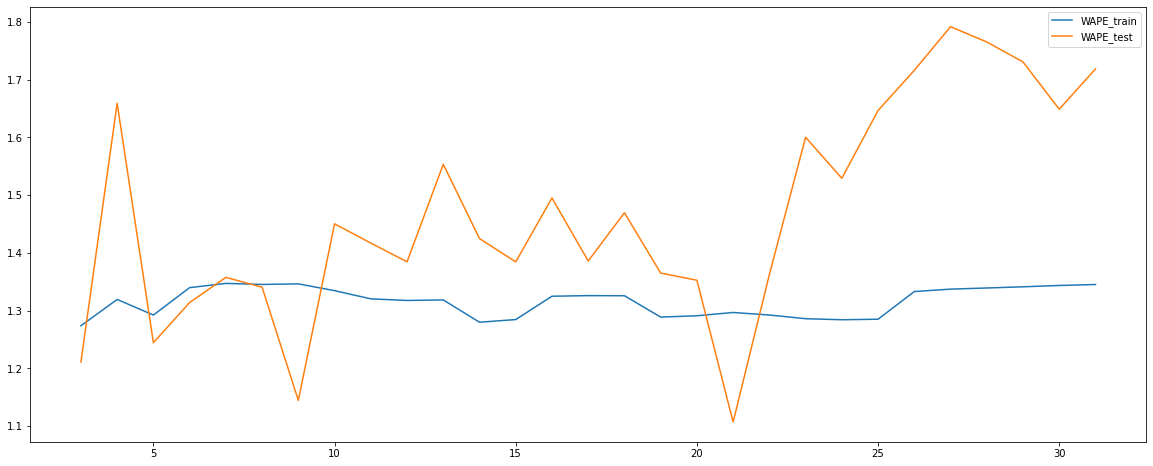

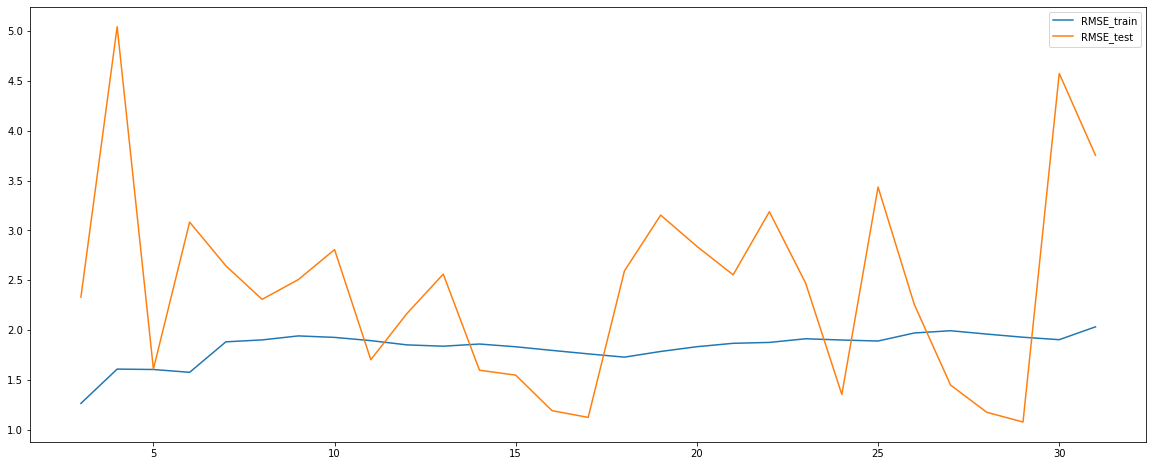

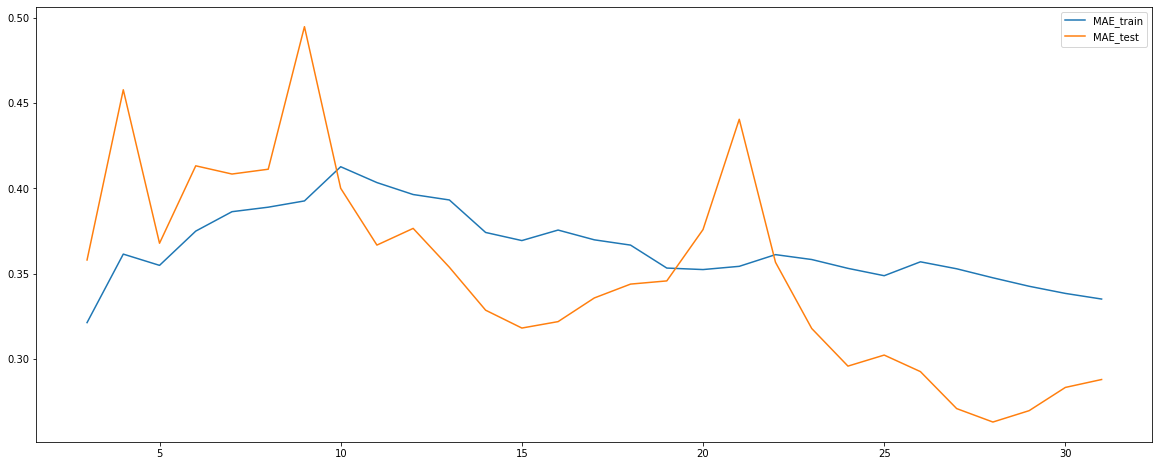

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


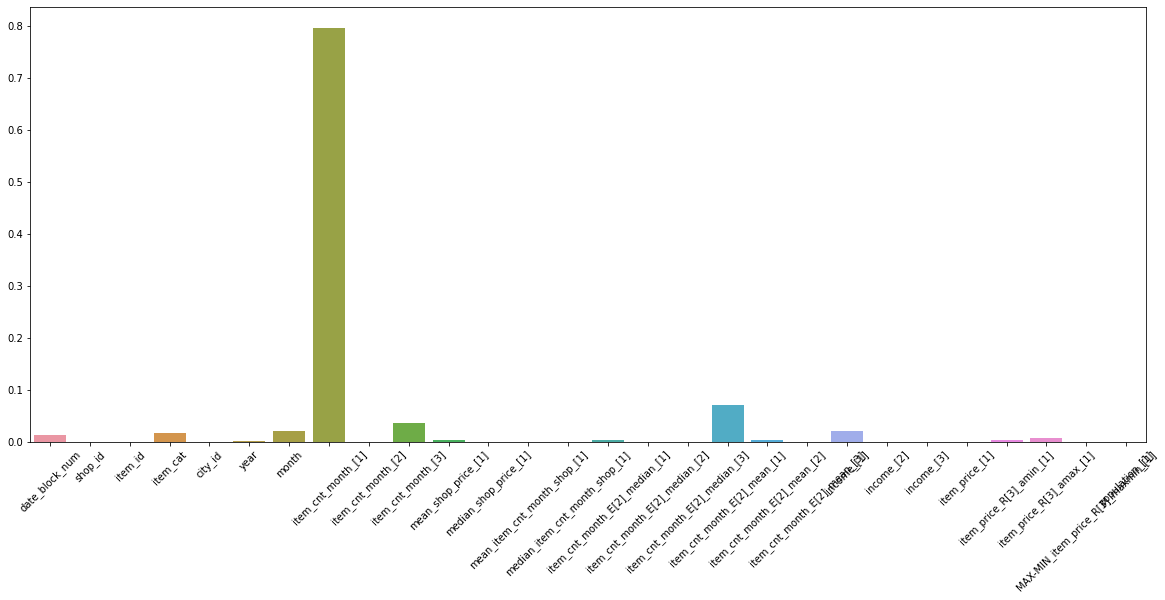

In [41]:
TRAIN_LOSS['DTR_5'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['DTR_5'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
DTR_5 = DecisionTreeRegressor(criterion='squared_error', max_depth=5)
DTR_5_fitted = validate_model(DTR_5, CV, TRAIN_LOSS['DTR_5'], TEST_LOSS['DTR_5'], print_count=True, to_numpy=True)
plot_losses(TRAIN_LOSS['DTR_5'], TEST_LOSS['DTR_5'])
sns.barplot(features, DTR_5_fitted.feature_importances_)
plt.xticks(rotation=45)
plt.show()

# DTR_2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


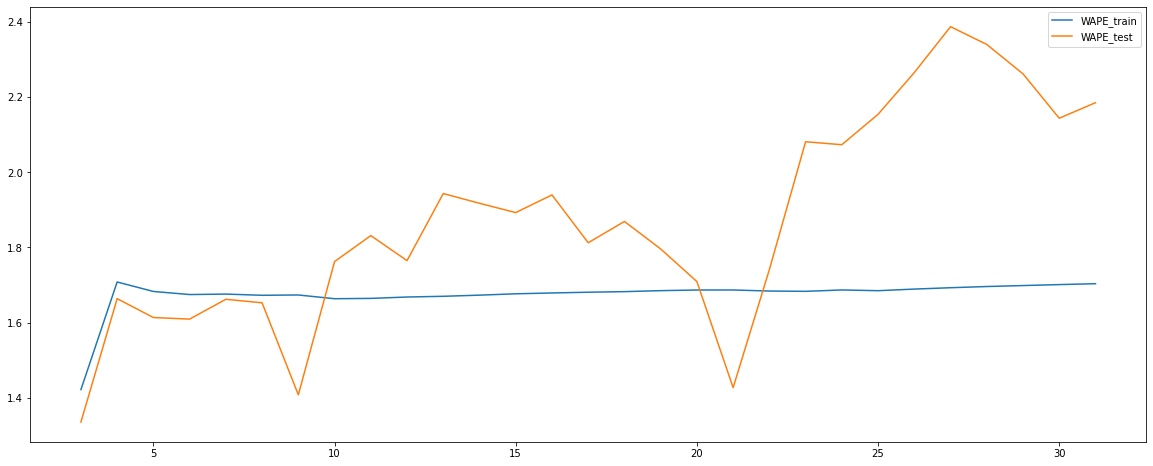

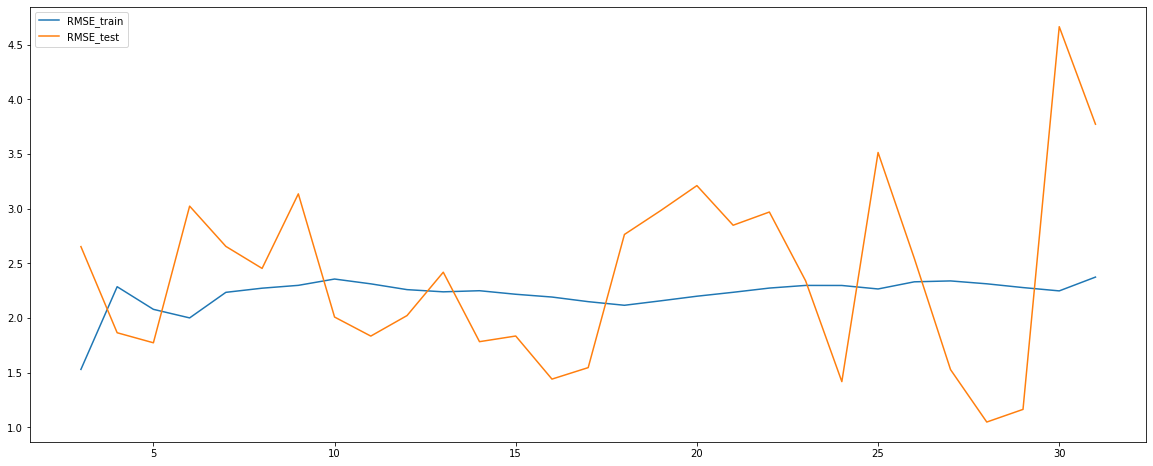

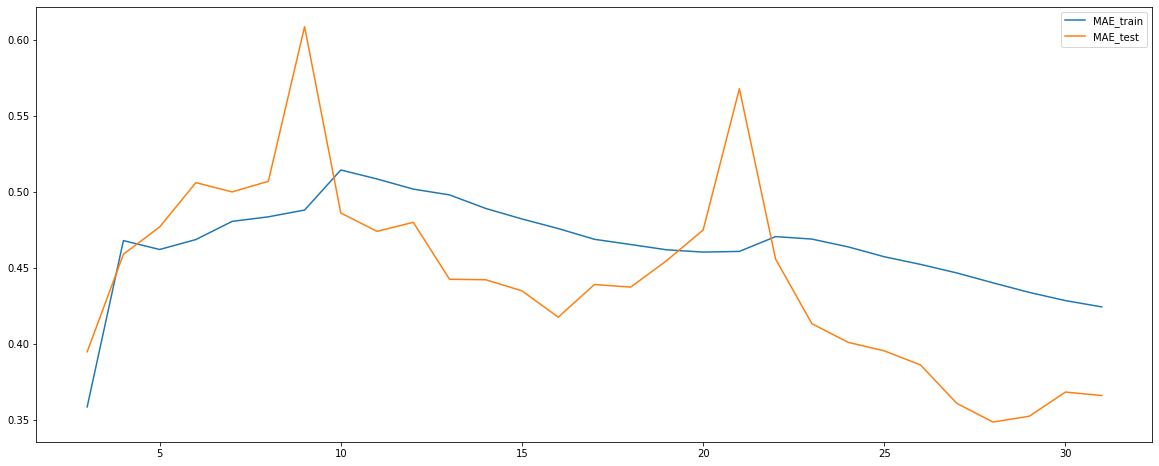

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


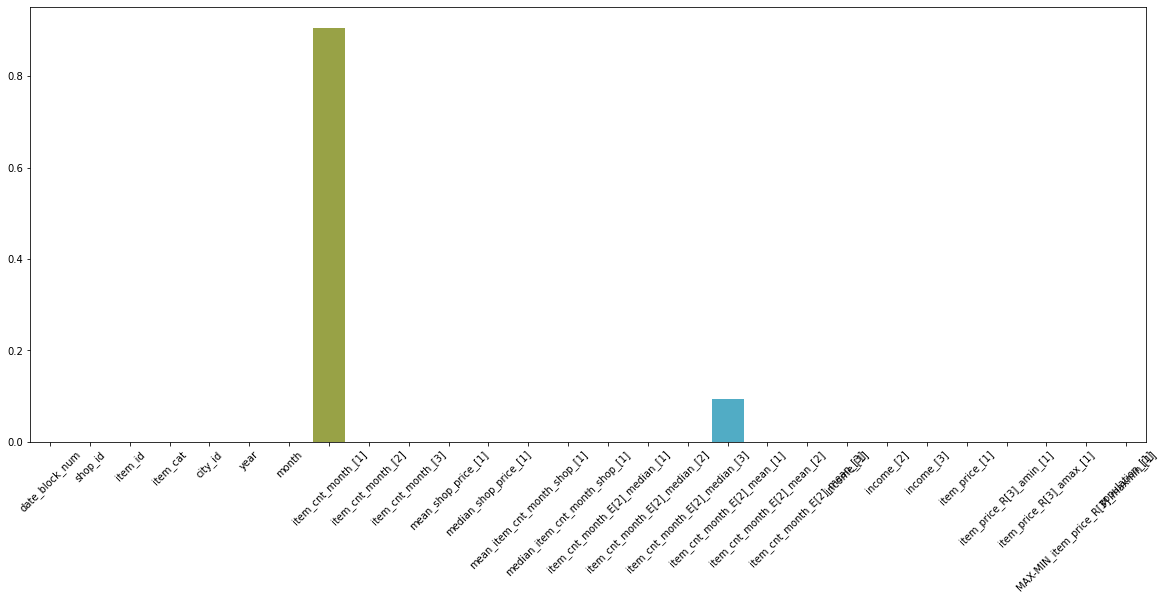

In [42]:
TRAIN_LOSS['DTR_2'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['DTR_2'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
DTR_2 = DecisionTreeRegressor(criterion='squared_error', max_depth=2)
DTR_2_fitted = validate_model(DTR_2, CV, TRAIN_LOSS['DTR_2'], TEST_LOSS['DTR_2'], print_count=True, to_numpy=True)
plot_losses(TRAIN_LOSS['DTR_2'], TEST_LOSS['DTR_2'])
sns.barplot(features, DTR_2_fitted.feature_importances_)
plt.xticks(rotation=45)
plt.show()

# DTR_30

In [ ]:
TRAIN_LOSS['DTR_30'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['DTR_30'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
DTR_30 = DecisionTreeRegressor(criterion='squared_error', max_depth=30)
DTR_30_fitted = validate_model(DTR_30, CV, TRAIN_LOSS['DTR_30'], TEST_LOSS['DTR_30'], print_count=True, to_numpy=True)
plot_losses(TRAIN_LOSS['DTR_30'], TEST_LOSS['DTR_30'])
sns.barplot(features, DTR_30_fitted.feature_importances_)
plt.xticks(rotation=45)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


# DTR absolute_error trains TOO long

In [ ]:
TRAIN_LOSS['DTR_ae'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['DTR_ae'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
for max_depth in [2,3,6,8,10,15]:
    DTR_ae = DecisionTreeRegressor(criterion='absolute_error', max_depth=max_depth)
    DTR_ae = validate_model(DTR_ae, CV, TRAIN_LOSS=TRAIN_LOSS['DTR_ae'], TEST_LOSS=TEST_LOSS['DTR_ae'], print_count=True)
    print(max_depth)
    plot_losses(TRAIN_LOSS['DTR_ae'],TEST_LOSS['DTR_ae'])
    sns.barplot(features,DTR.feature_importances_)
    plt.xticks(rotation=45)
    plt.show()
    print('========================================================\n')

1


KeyboardInterrupt: ignored

# CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
class CatBoostReg:
    def __init__(self, model, cat_features):
        self.model = model
        self.cat_features = cat_features
    def fit(self,X,y):
        self.fitted_model = self.model.fit(X,y,cat_features=self.cat_features)
    def predict(self,X):
        #print(type(X))
        return self.fitted_model.predict(X)

In [ ]:
cv_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cat', 'city_id', 'year',
       'month', 'item_cnt_month', 'item_cnt_month_[1]', 'item_cnt_month_[2]',
       'item_cnt_month_[3]', 'mean_shop_price_[1]', 'median_shop_price_[1]',
       'mean_item_cnt_month_shop_[1]', 'median_item_cnt_month_shop_[1]',
       'item_cnt_month_E[2]_median_[1]', 'item_cnt_month_E[2]_median_[2]',
       'item_cnt_month_E[2]_median_[3]', 'item_cnt_month_E[2]_mean_[1]',
       'item_cnt_month_E[2]_mean_[2]', 'item_cnt_month_E[2]_mean_[3]',
       'income_[1]', 'income_[2]', 'income_[3]', 'item_price_[1]',
       'item_price_R[3]_amin_[1]', 'item_price_R[3]_amax_[1]',
       'MAX-MIN_item_price_R[3]_maxmin_[1]', 'population_[1]'],
      dtype='object')

In [ ]:
#cat_features = [0,1,2,3,4,5,6]
cat_features = ['shop_id','item_id','date_block_num','item_cat','city_id','year','month','population_[1]']
CBR = CatBoostReg(CatBoostRegressor(
    iterations=600,
    learning_rate=0.03,
    task_type='CPU',
    depth=4
), cat_features=cat_features)

In [ ]:
cv_data[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 8275991 entries, 5 to 33
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   shop_id         uint8 
 1   item_id         uint16
 2   date_block_num  uint8 
 3   item_cat        uint8 
 4   city_id         uint8 
 5   year            uint8 
 6   month           uint8 
 7   population_[1]  uint16
dtypes: uint16(2), uint8(6)
memory usage: 142.1 MB


In [ ]:
TRAIN_LOSS['CBR'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['CBR'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}   
validate_model(CBR, CV, TRAIN_LOSS=TRAIN_LOSS['CBR'], TEST_LOSS=TEST_LOSS['CBR'],print_count=True, to_numpy=False)
plot_losses(TRAIN_LOSS['CBR'], TEST_LOSS['CBR'])

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbmreg = LGBMRegressor(
    boosting_type = 'gbdt',
    objective = 'regression',
    device_type = 'cpu',
    #metric ={l2, l1},
    num_leaves = 31,
    learning_rate = 0.05,
    #feature_fraction = 0.9,
    #bagging_fraction: 0.8,
    #bagging_freq: 5,
    verbose = 0
)

In [ ]:
features = [col for col in cv_data.columns if col != 'item_cnt_month']
target = ['item_cnt_month']

In [ ]:
lgbmreg.fit(cv_data[features], cv_data[target])

# Xgboost

In [ ]:
import xgboost

In [ ]:
class xgbRegressor:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.fit(X,y)
    def predict(self,X):
        return self.model.predict(X)

In [ ]:
TRAIN_LOSS['xgbReg'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
TEST_LOSS['xgbReg'] = {'WAPE' : [], 'RMSE' : [], 'MAE' : []}
xgbReg = xgbRegressor(xgboost.XGBRegressor(learning_rate=0.08))
xgbReg_fitted = validate_model(xgbReg, CV, TRAIN_LOSS['xgbReg'], TEST_LOSS['xgbReg'], print_count=True, to_numpy=True)
plot_losses(TRAIN_LOSS['xgbReg'], TEST_LOSS['xgbReg'])

[14:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
[14:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2
[14:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3
[14:41:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[14:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5
[14:43:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6
[14:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
7
[14:46:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated 

In [ ]:
cv_da